# Gaussian elimination to expose leaves

**Idea**: $b$-reduction as a method of exposing leaves has 2 limitations:
* Arbitrariness on the choice of $b$
* No control on how the compression rate changes

**Proposal**: 
* Build a graph with no leaves
* Instead of removing factors, do Gaussian elimination on the parity-check matrix which defines the graph
* Build a new graph from the matrix resulting after Gaussian elimination

The new graph will have some leaves (here we compute how many) while the space of solutions, hence the rate, is left untouched.

In [50]:
using Printf, Plots, ProgressMeter
include("../code/headers.jl")
include("../code/SimulationNEW.jl")

## How many leaves does Gaussian elimination expose?

At fixed rate $R=0.3$, let $n$ increase

In [43]:
const q = 2
nvals = Int.(floor.(10 .^(LinRange(1,3.1,7))))
R = 0.3
mvals = ceil.(Int, nvals.*(1-R))
niter = 50
randseed = 1234
variable_degrees = [[Dict{Int64,Float64}() for it in 1:niter] for n in 1:length(nvals)]
nleaves = [zeros(Int, niter) for n in 1:length(nvals)];

For each value of $n$, sample 50 random graphs and store the degree profiles to make some statistics

In [ ]:
for (i,n) in enumerate(nvals)
    println("n=$n. $i of $(length(nvals))")
    @showprogress for it in 1:niter
        lm = LossyModel(q, n, mvals[i], randseed=randseed+niter*i+it)
        gfref!(lm)
        nleaves[i][it] = nvarleaves(lm.fg)
        variable_degrees[i][it] = vardegrees_distr(lm.fg)
    end
end

Plot the average number of leaves as $n$ increases

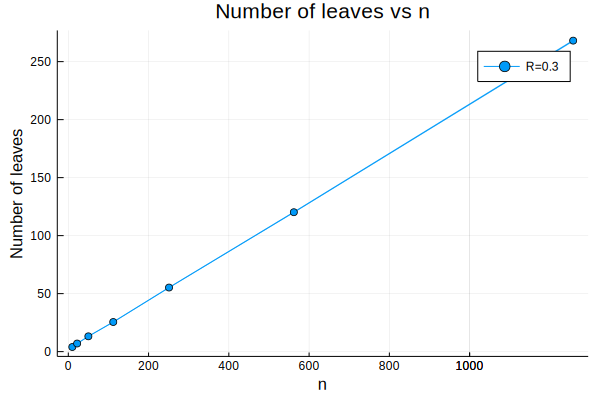

In [46]:
avg_leaves = [mean(nleaves[j]) for j in eachindex(nvals)]
sd_leaves = [std(nleaves[j])/sqrt(niter) for j in eachindex(nvals)]
plt = Plots.plot(nvals, avg_leaves, markershape=:circle, label="R=$R", ribbon=sd_leaves)
xlabel!("n")
ylabel!("Number of leaves")
title!("Number of leaves vs n")

In [47]:
slope = nvals\avg_leaves
@printf("Slope: %.2f\n", slope)

Slope: 0.21


## Estimate the proportionality constant between number of leaves and n as R varies

Repeat the procedure at the beginning of this notebook, for different rates.
For each rate, fit the slope from the $n$ vs $N_{leaves}$ plot

In [26]:
nvals = Int.(floor.(10 .^(LinRange(1,2.7,7))))
Rvals = 0.1:0.05:0.7
mvals = ceil.(Int, nvals.*(1-R))
niter = 50
randseed = 1234
nleaves_new = [[zeros(Int, niter) for n in 1:length(nvals)] for R in Rvals];

In [ ]:
for (r,R) in enumerate(Rvals)
    println("### R=$R. $r of $(length(Rvals))")
    mvals = ceil.(Int, nvals.*(1-R))
    @showprogress for (i,n) in enumerate(nvals)
        for it in 1:niter
            lm = LossyModel(q, n, mvals[i], randseed=randseed+niter*i+it)
            gfref!(lm)
            nleaves_new[r][i][it] = nvarleaves(lm.fg)
            variable_degrees[i][it] = vardegrees_distr(lm.fg)
        end
    end
end

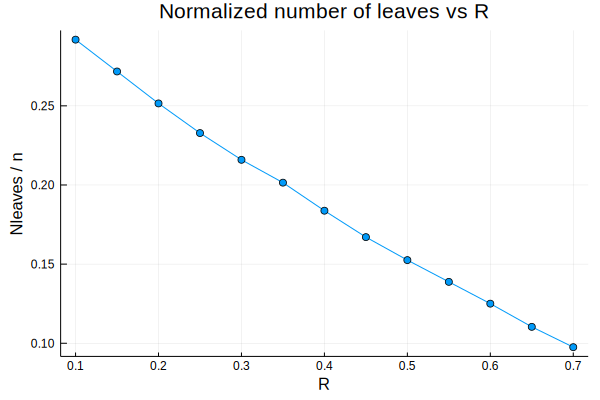

In [38]:
avg_leaves_new = [[mean(nleaves_new[r][j]) for j in eachindex(nvals)] for r in eachindex(Rvals)]
slopes = [nvals\avg_leaves_new[r] for r in eachindex(Rvals)]

plt = Plots.plot(Rvals, slopes, markershape=:circle, label="")
xlabel!("R")
ylabel!("Nleaves / n")
title!("Normalized number of leaves vs R")

## Compare with b-reduction in terms of compression performance

Run Max-Sum on graphs with $b$-reduction ($b=n/50$) first and then with Gaussian elimination. Same size, same compression rate

In [52]:
n = 1000
mvals = reverse(Int.(round.(n*(0.2:0.15:0.95))))
b = Int(round(n/50))
niter = 20
sims_b = Vector{Simulation{MS}}(undef, length(mvals))
sims_gauss = Vector{Simulation{MS}}(undef, length(mvals))
ms = MS(maxiter=200, gamma=1e-2);

In [ ]:
for (j,m) in enumerate(mvals)
    println("##### R = ", round(1-m/n, digits=2), ". ",
        "$j of $(length(mvals)) #####\n")
    sims_b[j] = Simulation(q, n, m, ms, b=b, randseed=randseed+200*j, 
        verbose=true, showprogress=false)
    sims_gauss[j] = Simulation(q, n, m, ms, b=0, gauss_elim=true,
        randseed=randseed+200*j, verbose=true, showprogress=false)
end

Plot the results

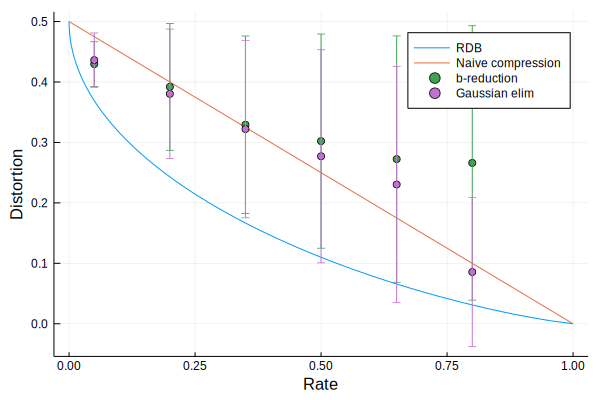

In [54]:
pl = plot(sims_b, label="b-reduction")
plot!(pl, sims_gauss, label="Gaussian elim")